# Predicting house prices: a regression example
_<span style="float:right; font-size:12px;">Norine NDOUDI</span>_

### **Loading the Boston housing dataset**

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [7]:
boston_housing

<module 'keras.datasets.boston_housing' from 'C:\\Users\\CYBER19\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\keras\\datasets\\boston_housing\\__init__.py'>

### **Preparing the data**

Because the values take wildly different ranges, we need to do a do feature-wise normalization to feed into a neural network the values. 

In [42]:
#Normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### **Building the neural network and choosing a loss function and an optimizer**

Because so few samples are available, we will use a small network with two hidden layers, each with 64 units in order to reduce the risk of overfitting

In [43]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()                                 
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    
    #linear layer because of no activation
    model.add(layers.Dense(1))

    #Choosing the mse loss function and the rmsprop optimizer
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### **Training the model**

Split the data into a training set and a validation set, as we did for the binary classification and the multiclass classification, could result in a variation of the validation scores might depending on which data points we chose to use for validation and which we chose for training because of a small validation set.  
In that case, we will use the ***K-fold cross-validation method.***

In [44]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    #Prepares the validation data: data from partition index i
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partitions
    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    #Builds the Keras model
    model = build_model()             
    
    #Trains the model running with 100 epochs
    model.fit(partial_train_data, partial_train_targets,                    
              epochs=num_epochs, batch_size=1, verbose=0)

    #Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)  
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [45]:
print(all_scores)
print(np.mean(all_scores))

[2.3666276931762695, 3.0213463306427, 2.5927090644836426, 2.545818567276001]
2.6316254138946533


In this case, we are off by 2,630USD on average, which is significant considering that the prices range from 10,000USD to 50,000USD.

Now we'll try to train the network a bit longer with 500 epochs and we will save the validation logs at each fold.

In [46]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(                                     
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()                                                    
    history = model.fit(partial_train_data, partial_train_targets,           
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

#Building the history of successive mean K-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


### **Plotting validation scores, excluding the first 10 data points**

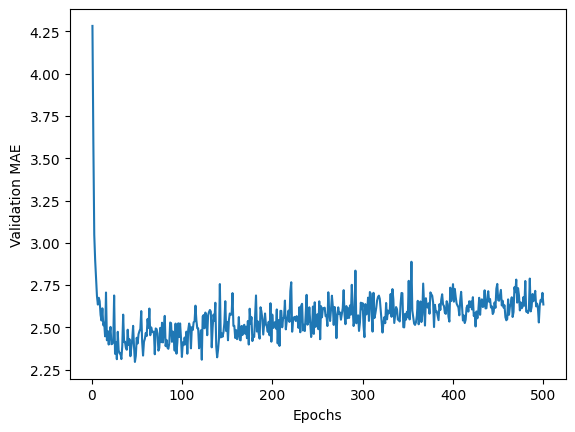

In [47]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

The plot of the validation scores can be difficult due to scaling issues and relatively high variance. We can't see if the network starts overfitting after some epochs. To deal with it, we will:
1. Omit the first 10 data points, which are on a different scale than the rest of the curve.
2. Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

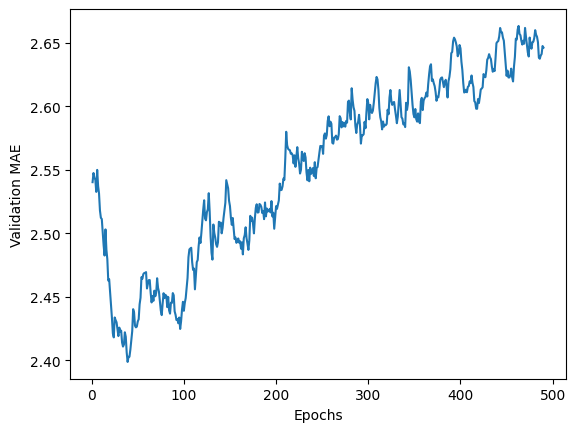

In [52]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### **Train a final production model on all of the training data**

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, the network starts overfitting.

In [53]:
model = build_model()                                                     
model.fit(train_data, train_targets,                                      
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 18.0883 - mae: 2.5576


2.5575573444366455

 We are still off by about $2,550 (we were off by 2,630USD on average)